# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "dataset_seeds_oracle.run2",
    "lr": 0.001,
    "device": "cuda",
    "seed": 1337,
    "dataset_seed": 12341234,
    "labels_source": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "labels_target": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "x_transforms_source": [],
    "x_transforms_target": [],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "num_examples_per_domain_per_label_source": 1000,
    "num_examples_per_domain_per_label_target": 1000,
    "n_shot": 3,
    "n_way": 16,
    "n_query": 2,
    "train_k_factor": 1,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source []
x_transforms_target []
Average magnitude, source: 0.004676534
Average power, source: 2.7930395e-05


Average magnitude, target: 0.0029711262
Average power, target: 1.154846e-05


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 420], examples_per_second: 9.5228, train_label_loss: 2.3317, 


epoch: 1, [batch: 42 / 420], examples_per_second: 850.0017, train_label_loss: 1.2861, 


epoch: 1, [batch: 84 / 420], examples_per_second: 923.4182, train_label_loss: 1.2115, 


epoch: 1, [batch: 126 / 420], examples_per_second: 996.7774, train_label_loss: 1.3198, 


epoch: 1, [batch: 168 / 420], examples_per_second: 1104.0041, train_label_loss: 1.0922, 


epoch: 1, [batch: 210 / 420], examples_per_second: 1210.5777, train_label_loss: 1.2817, 


epoch: 1, [batch: 252 / 420], examples_per_second: 1416.1613, train_label_loss: 1.1639, 


epoch: 1, [batch: 294 / 420], examples_per_second: 1471.8957, train_label_loss: 1.1389, 


epoch: 1, [batch: 336 / 420], examples_per_second: 1648.6541, train_label_loss: 0.9937, 


epoch: 1, [batch: 378 / 420], examples_per_second: 1881.5409, train_label_loss: 1.3090, 


epoch: 1, source_val_acc_label: 0.4719, target_val_acc_label: 0.3936, source_val_label_loss: 1.6044, target_val_label_loss: 1.7674, 


New best


epoch: 2, [batch: 1 / 420], examples_per_second: 5.1201, train_label_loss: 1.5091, 


epoch: 2, [batch: 42 / 420], examples_per_second: 829.4676, train_label_loss: 1.2332, 


epoch: 2, [batch: 84 / 420], examples_per_second: 899.3579, train_label_loss: 1.6104, 


epoch: 2, [batch: 126 / 420], examples_per_second: 984.1578, train_label_loss: 1.4158, 


epoch: 2, [batch: 168 / 420], examples_per_second: 1084.3207, train_label_loss: 1.6450, 


epoch: 2, [batch: 210 / 420], examples_per_second: 1234.3864, train_label_loss: 1.3179, 


epoch: 2, [batch: 252 / 420], examples_per_second: 1392.9598, train_label_loss: 1.2451, 


epoch: 2, [batch: 294 / 420], examples_per_second: 1509.1994, train_label_loss: 1.3077, 


epoch: 2, [batch: 336 / 420], examples_per_second: 1647.9086, train_label_loss: 1.4601, 


epoch: 2, [batch: 378 / 420], examples_per_second: 1880.3251, train_label_loss: 1.4914, 


epoch: 2, source_val_acc_label: 0.4766, target_val_acc_label: 0.3839, source_val_label_loss: 1.3017, target_val_label_loss: 1.9343, 


epoch: 3, [batch: 1 / 420], examples_per_second: 5.0920, train_label_loss: 1.3872, 


epoch: 3, [batch: 42 / 420], examples_per_second: 839.3050, train_label_loss: 1.4522, 


epoch: 3, [batch: 84 / 420], examples_per_second: 918.8055, train_label_loss: 1.1777, 


epoch: 3, [batch: 126 / 420], examples_per_second: 987.4829, train_label_loss: 1.1656, 


epoch: 3, [batch: 168 / 420], examples_per_second: 1105.8370, train_label_loss: 1.2683, 


epoch: 3, [batch: 210 / 420], examples_per_second: 1209.8159, train_label_loss: 1.3719, 


epoch: 3, [batch: 252 / 420], examples_per_second: 1363.6985, train_label_loss: 1.4945, 


epoch: 3, [batch: 294 / 420], examples_per_second: 1487.3706, train_label_loss: 1.1219, 


epoch: 3, [batch: 336 / 420], examples_per_second: 1636.3785, train_label_loss: 1.2559, 


epoch: 3, [batch: 378 / 420], examples_per_second: 1927.1333, train_label_loss: 1.0845, 


epoch: 3, source_val_acc_label: 0.4889, target_val_acc_label: 0.4072, source_val_label_loss: 1.2124, target_val_label_loss: 1.7496, 


New best


epoch: 4, [batch: 1 / 420], examples_per_second: 5.0638, train_label_loss: 1.4342, 


epoch: 4, [batch: 42 / 420], examples_per_second: 833.9766, train_label_loss: 1.4673, 


epoch: 4, [batch: 84 / 420], examples_per_second: 907.6859, train_label_loss: 1.3930, 


epoch: 4, [batch: 126 / 420], examples_per_second: 1008.1463, train_label_loss: 1.1389, 


epoch: 4, [batch: 168 / 420], examples_per_second: 1090.0489, train_label_loss: 1.2265, 


epoch: 4, [batch: 210 / 420], examples_per_second: 1230.4403, train_label_loss: 1.1951, 


epoch: 4, [batch: 252 / 420], examples_per_second: 1386.7644, train_label_loss: 1.4096, 


epoch: 4, [batch: 294 / 420], examples_per_second: 1529.3041, train_label_loss: 0.9913, 


epoch: 4, [batch: 336 / 420], examples_per_second: 1642.6006, train_label_loss: 1.1851, 


epoch: 4, [batch: 378 / 420], examples_per_second: 1909.9051, train_label_loss: 1.3351, 


epoch: 4, source_val_acc_label: 0.6559, target_val_acc_label: 0.5230, source_val_label_loss: 0.8869, target_val_label_loss: 1.4823, 


New best


epoch: 5, [batch: 1 / 420], examples_per_second: 5.0500, train_label_loss: 0.4964, 


epoch: 5, [batch: 42 / 420], examples_per_second: 821.6626, train_label_loss: 1.0201, 


epoch: 5, [batch: 84 / 420], examples_per_second: 917.1690, train_label_loss: 0.4050, 


epoch: 5, [batch: 126 / 420], examples_per_second: 1001.9838, train_label_loss: 0.6025, 


epoch: 5, [batch: 168 / 420], examples_per_second: 1103.2556, train_label_loss: 0.7552, 


epoch: 5, [batch: 210 / 420], examples_per_second: 1209.2933, train_label_loss: 0.8384, 


epoch: 5, [batch: 252 / 420], examples_per_second: 1370.6179, train_label_loss: 0.3823, 


epoch: 5, [batch: 294 / 420], examples_per_second: 1513.3352, train_label_loss: 0.9858, 


epoch: 5, [batch: 336 / 420], examples_per_second: 1632.9023, train_label_loss: 0.8326, 


epoch: 5, [batch: 378 / 420], examples_per_second: 1925.6926, train_label_loss: 1.2051, 


epoch: 5, source_val_acc_label: 0.7280, target_val_acc_label: 0.5758, source_val_label_loss: 0.7491, target_val_label_loss: 1.3301, 


New best


epoch: 6, [batch: 1 / 420], examples_per_second: 5.0632, train_label_loss: 0.5713, 


epoch: 6, [batch: 42 / 420], examples_per_second: 820.7109, train_label_loss: 0.3798, 


epoch: 6, [batch: 84 / 420], examples_per_second: 905.7262, train_label_loss: 0.6545, 


epoch: 6, [batch: 126 / 420], examples_per_second: 995.8441, train_label_loss: 0.3277, 


epoch: 6, [batch: 168 / 420], examples_per_second: 1093.7421, train_label_loss: 0.4965, 


epoch: 6, [batch: 210 / 420], examples_per_second: 1222.6395, train_label_loss: 0.4458, 


epoch: 6, [batch: 252 / 420], examples_per_second: 1363.7834, train_label_loss: 0.8094, 


epoch: 6, [batch: 294 / 420], examples_per_second: 1523.4989, train_label_loss: 0.4454, 


epoch: 6, [batch: 336 / 420], examples_per_second: 1633.8155, train_label_loss: 0.6501, 


epoch: 6, [batch: 378 / 420], examples_per_second: 1893.0718, train_label_loss: 0.7108, 


epoch: 6, source_val_acc_label: 0.7479, target_val_acc_label: 0.6080, source_val_label_loss: 0.6624, target_val_label_loss: 1.2513, 


New best


epoch: 7, [batch: 1 / 420], examples_per_second: 5.0754, train_label_loss: 0.3195, 


epoch: 7, [batch: 42 / 420], examples_per_second: 832.6265, train_label_loss: 0.8742, 


epoch: 7, [batch: 84 / 420], examples_per_second: 908.3846, train_label_loss: 0.5976, 


epoch: 7, [batch: 126 / 420], examples_per_second: 997.3100, train_label_loss: 0.7979, 


epoch: 7, [batch: 168 / 420], examples_per_second: 1094.9866, train_label_loss: 0.2698, 


epoch: 7, [batch: 210 / 420], examples_per_second: 1214.8740, train_label_loss: 0.1392, 


epoch: 7, [batch: 252 / 420], examples_per_second: 1326.9847, train_label_loss: 0.8556, 


epoch: 7, [batch: 294 / 420], examples_per_second: 1500.5863, train_label_loss: 0.7499, 


epoch: 7, [batch: 336 / 420], examples_per_second: 1636.7210, train_label_loss: 0.6062, 


epoch: 7, [batch: 378 / 420], examples_per_second: 1919.9971, train_label_loss: 0.5519, 


epoch: 7, source_val_acc_label: 0.7622, target_val_acc_label: 0.6179, source_val_label_loss: 0.6214, target_val_label_loss: 1.1796, 


New best


epoch: 8, [batch: 1 / 420], examples_per_second: 5.0898, train_label_loss: 0.3892, 


epoch: 8, [batch: 42 / 420], examples_per_second: 828.0041, train_label_loss: 0.4850, 


epoch: 8, [batch: 84 / 420], examples_per_second: 866.4516, train_label_loss: 0.1454, 


epoch: 8, [batch: 126 / 420], examples_per_second: 946.3208, train_label_loss: 1.1555, 


epoch: 8, [batch: 168 / 420], examples_per_second: 1039.1384, train_label_loss: 0.4659, 


epoch: 8, [batch: 210 / 420], examples_per_second: 1250.9508, train_label_loss: 0.5349, 


epoch: 8, [batch: 252 / 420], examples_per_second: 1243.0602, train_label_loss: 0.9213, 


epoch: 8, [batch: 294 / 420], examples_per_second: 1529.8579, train_label_loss: 0.5432, 


epoch: 8, [batch: 336 / 420], examples_per_second: 1618.1572, train_label_loss: 0.6063, 


epoch: 8, [batch: 378 / 420], examples_per_second: 1767.8176, train_label_loss: 0.8287, 


epoch: 8, source_val_acc_label: 0.7870, target_val_acc_label: 0.6164, source_val_label_loss: 0.5816, target_val_label_loss: 1.2181, 


epoch: 9, [batch: 1 / 420], examples_per_second: 5.1000, train_label_loss: 0.4974, 


epoch: 9, [batch: 42 / 420], examples_per_second: 827.5443, train_label_loss: 0.4343, 


epoch: 9, [batch: 84 / 420], examples_per_second: 905.1341, train_label_loss: 0.3056, 


epoch: 9, [batch: 126 / 420], examples_per_second: 970.6214, train_label_loss: 0.4960, 


epoch: 9, [batch: 168 / 420], examples_per_second: 1060.2693, train_label_loss: 0.6360, 


epoch: 9, [batch: 210 / 420], examples_per_second: 1206.3432, train_label_loss: 0.2672, 


epoch: 9, [batch: 252 / 420], examples_per_second: 1362.2584, train_label_loss: 0.4883, 


epoch: 9, [batch: 294 / 420], examples_per_second: 1585.2858, train_label_loss: 0.7094, 


epoch: 9, [batch: 336 / 420], examples_per_second: 1822.6960, train_label_loss: 0.7285, 


epoch: 9, [batch: 378 / 420], examples_per_second: 2274.7802, train_label_loss: 0.9196, 


epoch: 9, source_val_acc_label: 0.7814, target_val_acc_label: 0.6229, source_val_label_loss: 0.5893, target_val_label_loss: 1.2323, 


epoch: 10, [batch: 1 / 420], examples_per_second: 5.3415, train_label_loss: 0.5124, 


epoch: 10, [batch: 42 / 420], examples_per_second: 862.4184, train_label_loss: 0.4675, 


epoch: 10, [batch: 84 / 420], examples_per_second: 928.8500, train_label_loss: 0.6311, 


epoch: 10, [batch: 126 / 420], examples_per_second: 997.4984, train_label_loss: 0.5629, 


epoch: 10, [batch: 168 / 420], examples_per_second: 1135.4147, train_label_loss: 0.6150, 


epoch: 10, [batch: 210 / 420], examples_per_second: 1238.4530, train_label_loss: 0.4959, 


epoch: 10, [batch: 252 / 420], examples_per_second: 1393.8484, train_label_loss: 0.5341, 


epoch: 10, [batch: 294 / 420], examples_per_second: 1627.5882, train_label_loss: 0.2893, 


epoch: 10, [batch: 336 / 420], examples_per_second: 1895.1489, train_label_loss: 0.3883, 


epoch: 10, [batch: 378 / 420], examples_per_second: 2334.9593, train_label_loss: 0.4638, 


epoch: 10, source_val_acc_label: 0.7859, target_val_acc_label: 0.6300, source_val_label_loss: 0.5805, target_val_label_loss: 1.3513, 


epoch: 11, [batch: 1 / 420], examples_per_second: 5.4236, train_label_loss: 0.6148, 


epoch: 11, [batch: 42 / 420], examples_per_second: 860.3399, train_label_loss: 0.2033, 


epoch: 11, [batch: 84 / 420], examples_per_second: 941.4130, train_label_loss: 0.6787, 


epoch: 11, [batch: 126 / 420], examples_per_second: 1031.1713, train_label_loss: 0.5687, 


epoch: 11, [batch: 168 / 420], examples_per_second: 1118.0902, train_label_loss: 0.3660, 


epoch: 11, [batch: 210 / 420], examples_per_second: 1258.0316, train_label_loss: 0.6080, 


epoch: 11, [batch: 252 / 420], examples_per_second: 1409.9666, train_label_loss: 0.1071, 


epoch: 11, [batch: 294 / 420], examples_per_second: 1630.2384, train_label_loss: 0.3001, 


epoch: 11, [batch: 336 / 420], examples_per_second: 1878.4418, train_label_loss: 0.6936, 


epoch: 11, [batch: 378 / 420], examples_per_second: 2269.7569, train_label_loss: 0.4507, 


epoch: 11, source_val_acc_label: 0.7795, target_val_acc_label: 0.6303, source_val_label_loss: 0.5932, target_val_label_loss: 1.3103, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

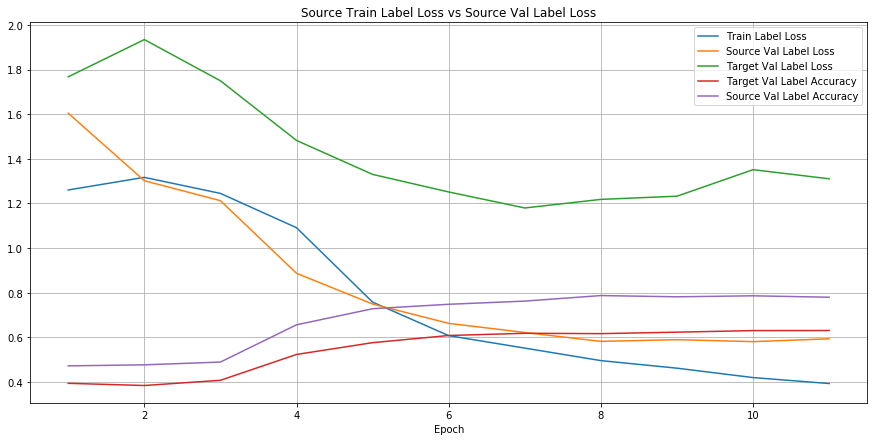

In [16]:
ax = get_loss_curve(experiment)
plt.show()

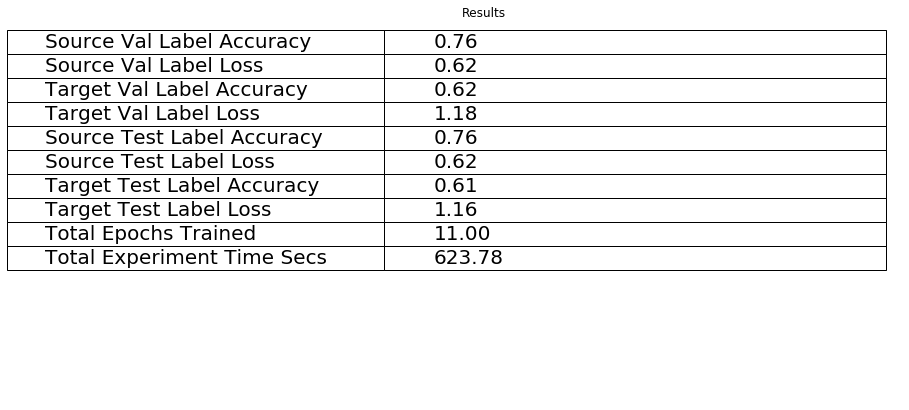

In [17]:
get_results_table(experiment)

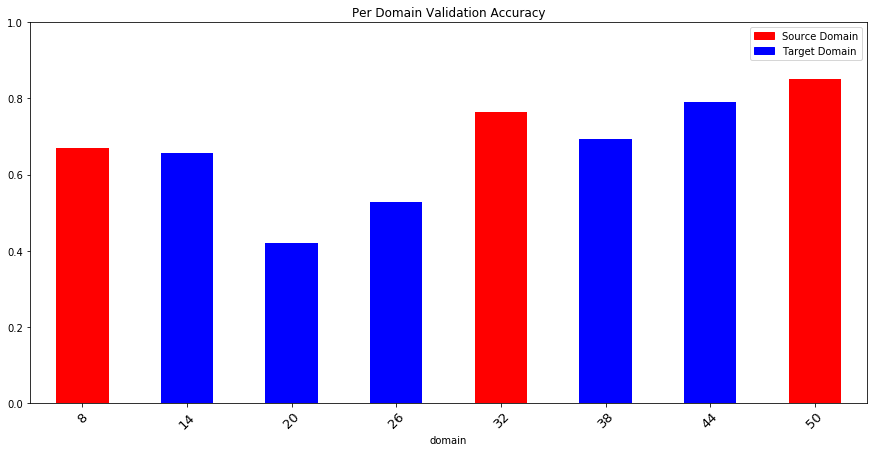

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7612847222222222 Target Test Label Accuracy: 0.6098958333333333
Source Val Label Accuracy: 0.7621527777777778 Target Val Label Accuracy: 0.6179166666666667


In [20]:
json.dumps(experiment)

'{"experiment_name": "dataset_seeds_oracle.run2", "parameters": {"experiment_name": "dataset_seeds_oracle.run2", "lr": 0.001, "device": "cuda", "seed": 1337, "dataset_seed": 12341234, "labels_source": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "labels_target": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "x_transforms_source": [], "x_transforms_target": [], "episode_transforms_source": [], "episode_transforms_target": [], "num_examples_per_domain_per_label_source": 1000, "num_examples_per_domain_per_label_target": 1000, "n_shot": 3, "n_way": 16, "n_query": 2, "train_k_factor": 1, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_loss", 